# Feed-Forward Network Notebook
Authors : Vandan Shah, Samit Sharma, Sneha Parikh

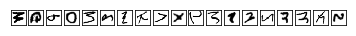

In [25]:
from scipy import io as sio
import pickle
import gzip
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random

def createZipFile() :
    mat = sio.loadmat('emnist-letters.mat')
    data = mat['dataset']

    X_train = data['train'][0,0]['images'][0,0]
    y_train = data['train'][0,0]['labels'][0,0]
    X_test = data['test'][0,0]['images'][0,0]
    y_test = data['test'][0,0]['labels'][0,0]
    val_start = X_train.shape[0] - X_test.shape[0]
    X_val = X_train[val_start:X_train.shape[0],:]
    y_val = y_train[val_start:X_train.shape[0]]
    X_train = X_train[0:val_start,:]
    y_train = y_train[0:val_start]

    X_train1 = [X_train]
    y_train1 = [y_train]
    X_test1  = [X_test]
    y_test1  = [y_test]
    X_val1   = [X_val]
    y_val1   = [y_val]

    X_train = list(zip(X_train1,y_train1))
    X_test  = list(zip(X_test1,y_test1))
    X_val   = list(zip(X_val1,y_val1))
            

    f = gzip.open('emnist.pkl.gz','wb')
    pickle.dump(X_train+X_val+X_test,f)
    f.close()
    
def loadCompressedFile() :
    f = gzip.open('emnist.pkl.gz','rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return training_data,validation_data,test_data


def load_data_wrapper() :
    tr_d, va_d, te_d = loadCompressedFile()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    e = np.zeros((27, 1))
    e[j] = 1.0
    return e

#load_data_wrapper()

def plot_images_separately(images):
    fig = plt.figure()
    for j in range(1,20):
        ax = fig.add_subplot(1,19, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()


def get_images(training_set):
    flattened_images = training_set[0]
    return [np.reshape(f, (-1, 28)) for f in flattened_images]

def main():
    training_set, validation_set, test_set = loadCompressedFile()
    images = get_images(training_set)
    plot_images_separately(images)
    
main()

class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ('Epoch {0}: {1} / {2}'.format(
                    j, self.evaluate(test_data), n_test))
            else:
                print ('Epoch {0} complete'.format(j))

    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))


epochslist=[]
class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        return (a-y)


class Network2(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost
        
    def default_weight_initializer(self):
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) 
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
     
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta,
        lmbda = 0.0,
        evaluation_data=None,
        monitor_evaluation_cost=False,
        monitor_evaluation_accuracy=False,
        monitor_training_cost=False,
        monitor_training_accuracy=False):
       
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            print ('Epoch %s training complete' % j)
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print ('Cost on training data: {}'.format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print ('Accuracy on training data: {} / {}'.format(
                    accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print ('Cost on evaluation data: {}'.format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print ('Accuracy on evaluation data: {} / {}'.format(
                    self.accuracy(evaluation_data), n_data))
            print('')
            epochslist.append(j)
        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy
    
    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)
    
    def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost
    
    def accuracyonTestData(self,test_data):
        acc = self.accuracy(test_data)
        acc=(acc*100.0)/20800
        print('Accuacy on test data is : {}'.format(acc))
    
def vectorized_result(j):
    e = np.zeros((27, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

def plotGraphCost(trainingCost,validationCost,epochs) : 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(0,len(epochs)), 
            trainingCost[0:len(epochs)])
    ax.plot(np.arange(0,len(epochs)), 
            validationCost[0:len(epochs)])
    ax.set_xlim([0, len(epochs)-1])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.legend(['Cost on Training Data', 'Cost on Validation Data'], loc='lower right')
    ax.set_title('Cost')
    
    plt.show()
    
def plotGraphAccuracy(trainingAccuracy,validationAccuracy,epochs,trainingSize,validationSize) : 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(0,len(epochs)), 
            [(acc*100.0)/trainingSize 
             for acc in trainingAccuracy[0:len(epochs)]])
    ax.plot(np.arange(0,len(epochs)), 
            [(acc*100.0)/validationSize 
             for acc in validationAccuracy[0:len(epochs)]])
    ax.set_xlim([0, len(epochs)-1])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.legend(['Accuracy on Training Data', 'Accuracy on Validation Data'], loc='lower right')
    ax.set_title('Accuracy')
    plt.show()
    
    
def runNetwork2():
    training_data, validation_data, test_data = load_data_wrapper()
    net = Network2([784,120, 27], cost=CrossEntropyCost)
    evaluation_cost, evaluation_accuracy,training_cost, training_accuracy = net.SGD(list(training_data),30,1000,0.1, lmbda =1.0, evaluation_data=list(validation_data), monitor_evaluation_accuracy=True, monitor_evaluation_cost=True, monitor_training_accuracy=True,monitor_training_cost=True)

    plotGraphCost(training_cost,evaluation_cost,epochslist)
    plotGraphAccuracy(training_accuracy,evaluation_accuracy,epochslist,104000,20800)
    net.accuracyonTestData(list(test_data))
    
def runNetwork1():
    training_set, validation_set, test_set = load_data_wrapper()
    ffn = Network([784,120,27])
    ffn.SGD(list(training_set),30,1000,0.1,test_data=list(test_set))


Epoch 0 training complete
Cost on training data: 4.253024149622653
Accuracy on training data: 4000 / 104000
Cost on evaluation data: 4.279022206453973
Accuracy on evaluation data: 800 / 20800

Epoch 1 training complete
Cost on training data: 4.249300967326974
Accuracy on training data: 4000 / 104000
Cost on evaluation data: 4.2753029010085815
Accuracy on evaluation data: 800 / 20800



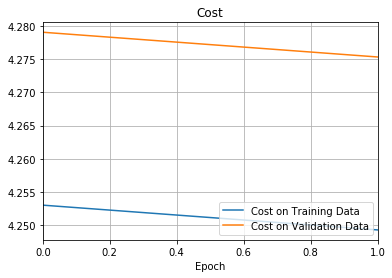

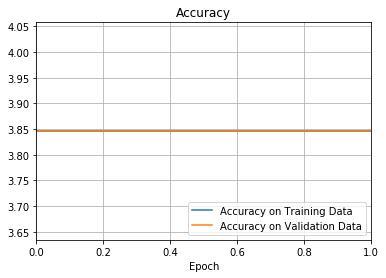

Accuacy on test data is : 3.8461538461538463


In [26]:
runNetwork2()

In [27]:
runNetwork1()

Epoch 0: 683 / 20800
Epoch 1: 693 / 20800
